In [1]:
import matplotlib
from graph_tool.all import *
import numpy as np
import pickle
import matplotlib.pyplot as plt
import time
import datetime
import pytz

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [219]:
def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" % tempTimeInterval )

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)

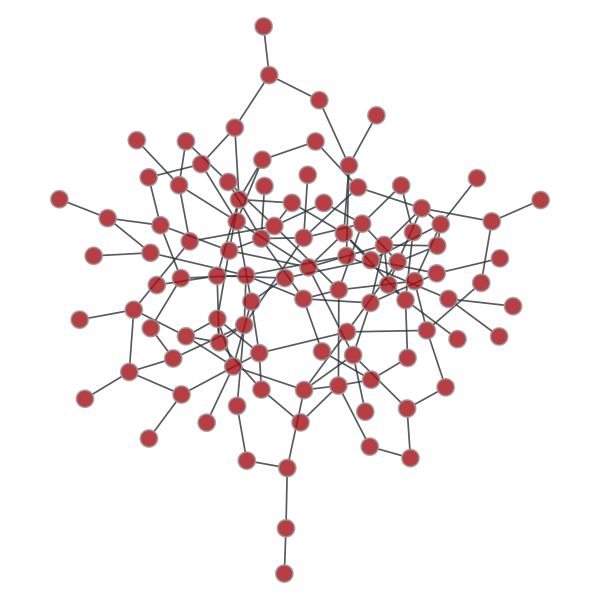

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f6f8a2d8be0, at 0x7f6f8b486e10>

In [121]:
# Random ints between 1 and 5. Pass to graph-tool's random graph generator
def deg_sampler():
    return np.random.randint(1,6)

# Plotting an example graph with degree between 1 and 6
h = random_graph(100, deg_sampler, verbose=True, directed=False)
pos = graph_tool.draw.sfdp_layout(h)
graph_draw(h, pos=pos)

In [1]:
# Opens network file, splits each line into a list of integers
f = open("facebook_combined.txt","r")
lines = [[int(n) for n in x.split()] for x in f.readlines()]
f.close()

# Build graph
g = Graph(directed=False)

# Adds enough vertices (the "1 + " is for position 0)
g.add_vertex(1 + max([l[0] for l in lines] + [l[1] for l in lines]))

for line in lines:
    # Make a new edge
    g.add_edge(g.vertex(line[0]),g.vertex(line[1]))

NameError: name 'Graph' is not defined

## Network Topology & Statistics

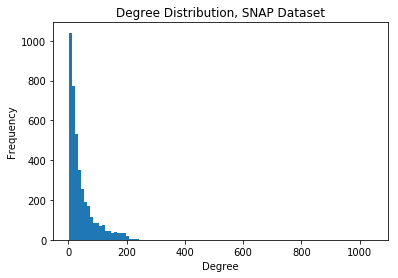

In [241]:
plt.hist(g.get_out_degrees(g.get_vertices()),bins=100)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution, SNAP Dataset')
plt.show()

In [187]:
p = g.num_vertices()
q = g.num_edges()
density = q  /  (p * (p - 1) / 2)

print('There are {0} vertices'.format(p))
print('There are {0} edges'.format(q))
print('Graph density is {0}'.format(density))


There are 4039 vertices
There are 88234 edges
Graph density is 0.010819963503439287


In [193]:
print("Global".format(global_clustering(g)))

(0.5191742775433075, 0.037513208713051076)

In [ ]:
pos_snap = graph_tool.draw.sfdp_layout(g)

In [196]:
c = closeness(g)

graph_draw(
    g, 
    pos = pos_snap,
    vertex_fill_color=c,
    vertex_size=prop_to_size(c, mi=1, ma=4),
    vcmap=matplotlib.cm.gist_heat,
    edge_pen_width=0.3,
    vorder=c, 
    size=(10000,10000),
    bg_color=[1,1,1,0.8],
    output="SNAP_closeness.png"
)

/usr/lib/python3.6/site-packages/graph_tool/draw/cairo_draw.py:637: UserWarning: Unknown parameter: size
  warnings.warn("Unknown parameter: " + k, UserWarning)


<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f6f8b42ebe0, at 0x7f6f8ce17a90>

In [243]:
# Inferring structure of network with SBM
state = minimize_blockmodel_dl(g)
state.draw(pos=pos,bg_color=[0,0,0,1], output="SNAP_blockmodel.png",)

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f6f8b42ebe0, at 0x7f6f8b341470>

## Monte Carlo Simulation

In [197]:
class SimulationOutcome():
    def __init__(self, first_spreader_idx, first_spreader_degree, duration, rumor_size):
        self.first_spreader_idx = first_spreader_idx
        self.first_spreader_degree = first_spreader_degree
        self.duration = duration
        self.rumor_size = rumor_size

In [413]:
print(datetime.datetime.now(tz))

np.random.seed(420)

I_colour = [0, 1, 0, 0.5]
S_colour = [1, 0, 0, 0.7]
R_colour = [0, 0, 1, 0.5]
bg = [1, 1, 1, 0.8]
I, S, R = -1, 0, 1
out_size = (750, 750)

colour = h.new_vertex_property("vector<double>")
status = h.new_vertex_property("int16_t")
newly_infected = h.new_vertex_property("bool")

# Fix layout of vertices for plotting
pos = graph_tool.draw.sfdp_layout(g)

draw = False

# SIR model parameters
lmbda = 0.2
gamma = 0.05
eta = 0.1
delta = 0.5
num_sims = 2

PIK = "sim_output/sims_test.dat"
sims = []

tic()
for i in range(num_sims):
    if i % 25 == 0:
        print('-----------')
        print('SIMULATION: {0}'.format(i))
        print(datetime.datetime.now(tz))

    # Set all users to Ignorant
    status.a = I
    for v in h.vertices():
        colour[v] = I_colour
    
    # Start with one random spreader
    first_spreader = np.random.randint(0,h.num_vertices())
    colour[first_spreader] = S_colour        
    status.a[first_spreader] = S
    
    # Draw initial state
    if draw:
        graph_draw(
            h, 
            pos=pos,
            vertex_fill_color=colour,
            vertex_color=colour,
            output_size=out_size,
            bg_color=bg,
            edge_pen_width=0.5,
            output='sim_output/sir_{0}.png'.format(0)
        )
    
    rumor_size_acc = [np.float(np.mean(status.a >= 0))]

    t = 0

    # Terminate when no spreaders remain
    while np.sum(status.a == S) > 0:
        t += 1
        spreaders = np.transpose((status.a == S).nonzero()).flatten()
        np.random.shuffle(spreaders)
        newly_infected.a = False

        for v in spreaders:
            neis = h.get_in_neighbours(v)
            neis_statuses = status.a[neis]
            I_neis = neis[neis_statuses == I]
            S_neis = neis[neis_statuses == S]
            R_neis = neis[neis_statuses == R]

            n_I_neis = len(I_neis)
            n_S_neis = len(S_neis)
            n_R_neis = len(R_neis)

            # If all neighbours are stiflers, current spreader becomes a stifler
            if np.all(neis_statuses == R):
                status.a[v] = R
                
            # Spreader-ignorant contact
            if n_I_neis > 0:
                r_lambda = np.random.random(n_I_neis)
                I_to_S = I_neis[r_lambda <= lmbda]
                I_to_R = I_neis[~(r_lambda < lmbda)]

                status.a[I_to_S] = S
                status.a[I_to_R] = R

                for w in I_to_S:
                    colour[w] = S_colour
                    newly_infected[w] = True

            # Spreader-spreader contact
            if n_S_neis > 0:
                r_gamma = np.random.random(n_S_neis)

                if np.any(r_gamma < gamma):
                    status.a[v] = R

            # Spreader-stifler contact
            if n_R_neis > 0:
                r_eta = np.random.random(n_R_neis)


                if np.any(r_eta < eta):
                    status.a[v] = R

            # Forget probability
            if np.random.random() < delta:
                status.a[v] = R

            curr_stiflers = np.transpose((status.a == R).nonzero()).flatten()
            
            # Update colours of stiflers
            for w in curr_stiflers:
                colour[w] = R_colour
          
        if draw:
            graph_draw(
                h, 
                pos=pos,
                vertex_fill_color=colour,
                vertex_color=colour,
                vertex_halo=newly_infected,
                vertex_halo_color=[1, 1, 0, 1], 
                output_size=out_size, 
                bg_color=bg,
                edge_pen_width=0.5,
                output='sim_output/sir_{0}.png'.format(t),
            )

        curr_rumor_size = np.float(np.mean(status.a >= 0))
        rumor_size_acc += [curr_rumor_size]

    curr_sim = SimulationOutcome(first_spreader,
                        len(h.get_in_neighbours(first_spreader)),
                        t,
                        rumor_size_acc)
    sims += [curr_sim]
    
    # Pickle sim data to a file
    with open(PIK, "wb") as f:
        pickle.dump(sims, f)

print(datetime.datetime.now(tz))
toc()

2018-11-25 12:01:43.060682-05:00
-----------
SIMULATION: 0
2018-11-25 12:01:43.063691-05:00
-----------
SIMULATION: 25
2018-11-25 12:18:38.194496-05:00
-----------
SIMULATION: 50
2018-11-25 12:36:36.288375-05:00
-----------
SIMULATION: 75
2018-11-25 13:01:25.489235-05:00
2018-11-25 13:24:53.838274-05:00
Elapsed time: 4990.777474 seconds.



## Analysis

In [415]:
# Load simulation results file
with open(PIK, "rb") as f:
    data = pickle.load(f)

print(len(data))

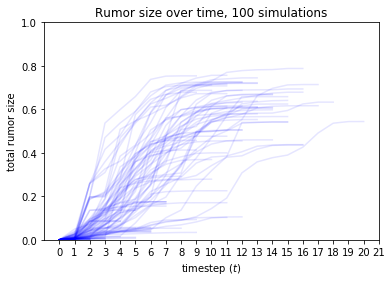

In [462]:
for i in range(len(data)):
    plt.plot(data[i].rumor_size,alpha=0.1,color='b')

plt.ylim(0,1)
plt.xticks(range(max(t)+2))
plt.title('Rumor size over time, {0} simulations'.format(num_sims))
plt.xlabel('timestep ($t$)')
plt.ylabel('total rumor size')
plt.savefig('montecarlo_rumor_size.png')
plt.show()

In [ ]:
# Filtering above plot for sims that reached a certain rumor size
for i in range(len(data)):
    if data[i].rumor_size[-1] > 0.4:
        plt.plot(data[i].rumor_size,alpha=0.1,color='b')

plt.ylim(0, 1)
plt.xticks(range(max(t)+2))
plt.title('Rumor size over time, {0} simulations'.format(num_sims))
plt.xlabel('timestep ($t$)')
plt.ylabel('total rumor size')
plt.savefig('montecarlo_rumor_size.png')
plt.show()

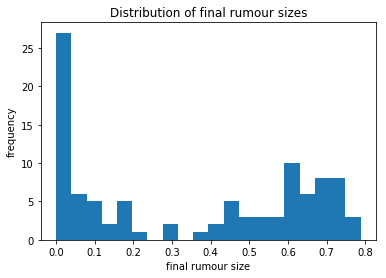

In [463]:
plt.hist(r, bins=20)
plt.title('Distribution of final rumour sizes')
plt.xlabel('final rumour size')
plt.ylabel('frequency')
plt.savefig('montecarlo_rumor_disbn.png')
plt.show()

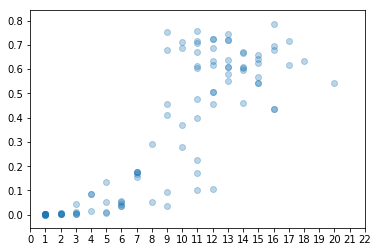

In [465]:
# Duration of sim vs final rumour size
t = np.array([s.duration for s in data])
d = np.array([s.first_spreader_degree for s in data])
idxs = np.array([s.first_spreader_idx for s in data])
r = np.array([s.rumor_size[-1] for s in data])
plt.scatter(t, r, alpha=0.3)
plt.xticks(range(max(t)+3))
plt.show()

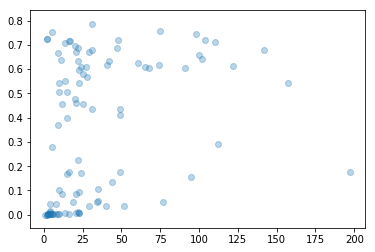

In [429]:
# Degree of the first spreader vs final rumour size
plt.scatter(d, r, alpha=0.3)
plt.show()

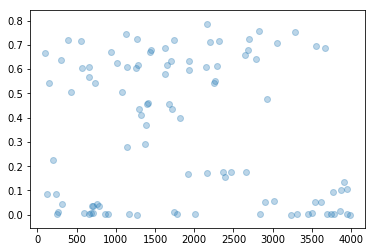

In [451]:
# Index of first spreader vs final rumour size
plt.scatter(idxs, r, alpha=0.3)
# plt.xticks(range(max(t)+3))
plt.show()

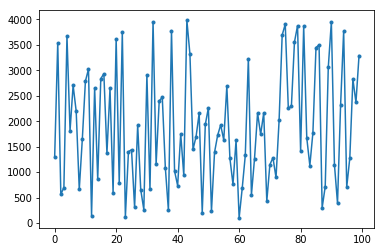

In [442]:
# Check if first spreader's index is random for each
plt.plot([s.first_spreader_idx for s in data], marker='.')
plt.show()

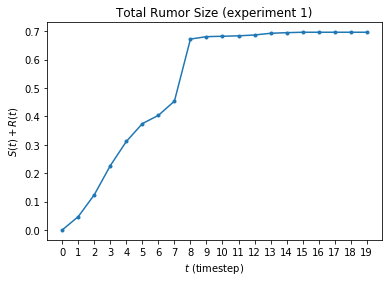

In [215]:
plt.plot(rumor_size_acc, marker='.')
plt.title('Total Rumor Size (experiment 1)')
plt.xticks(np.arange(0,len(rumor_size_acc)))
plt.xlabel('$t$ (timestep)')
plt.ylabel('$S(t)+R(t)$')
plt.savefig('rumorsize_exp1.png')
plt.show()